In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedGroupKFold,\
GroupShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.visualization.matplotlib import plot_param_importances

from metrics import get_metrics, check_overfitting

import warnings

warnings.filterwarnings('ignore')

RAND = 10

In [10]:
ROOT = "../"

RAND = 10
N_SPLIT_TRAIN = 0.18
N_SPLIT_VAL = 0.15
N_FOLDS = 5

# Overview
Данные взяты из соревания на Kaggle. Основная информация по данным представлена здесь https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data

Цель - предсказать, какие клиенты с большей вероятностью не смогут выплатить свои кредиты и оценка должна быть стабильна с течением времени

# Prepare data

In [21]:
df_train = pd.read_parquet(f"{ROOT}train4.parquet")

In [27]:
metrics = pd.read_csv(f"baseline_metrics.csv")

In [12]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
print(X.shape)

(1526659, 242)


In [13]:
def train_test_split_by_groups(X: pd.DataFrame,
                               y: pd.Series,
                               groups: pd.Series,
                               test_size=None,
                               train_size=None,
                               random_state=None,
                               shuffle=True):
    """
    Split arrays or matrices into random train and test subsets 
    according groups.
    """
    if shuffle:
        gss = GroupShuffleSplit(n_splits=1,
                                test_size=test_size,
                                train_size=train_size,
                                random_state=random_state)
        train_idx, test_idx = next(gss.split(X, y, groups))
        return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx],\
            y.iloc[test_idx], groups.iloc[train_idx], groups.iloc[test_idx]
    else:
        return train_test_split(X,
                                y,
                                groups,
                                test_size=test_size,
                                train_size=train_size,
                                shuffle=False,
                                random_state=RAND)

In [14]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split_by_groups(
    X, y, weeks, test_size=N_SPLIT_TRAIN, random_state=RAND)

X_train_, X_val, y_train_, y_val, w_train_, w_val = train_test_split_by_groups(
    X_train, y_train, w_train, test_size=N_SPLIT_VAL, random_state=RAND)

print(f"All train: {round(X_train.shape[0] / X.shape[0] * 100, 2)}%")
print(f"train: {round(X_train_.shape[0] / X.shape[0] * 100, 2)}%")
print(f"val: {round(X_val.shape[0] / X.shape[0] * 100, 2)}%")
print(f"test: {round(X_test.shape[0] / X.shape[0] * 100, 2)}%")

All train: 79.67%
train: 65.35%
val: 14.31%
test: 20.33%


In [15]:
X_bin = pd.get_dummies(X)

X_train_bin, X_test_bin, y_train_bin,\
    y_test_bin, w_train_bin, w_test_bin = train_test_split_by_groups(
    X_bin, y, weeks, test_size=N_SPLIT_TRAIN, random_state=RAND)

print(f"All train: {round(X_train_bin.shape[0] / X.shape[0] * 100, 2)}%")
print(f"test: {round(X_test_bin.shape[0] / X.shape[0] * 100, 2)}%")
print(X_bin.shape)

All train: 79.67%
test: 20.33%
(1526659, 661)


# Tuning

## LightGBM Tuning 

### 300 estimators

#### Search learning_rate

In [19]:
def lgb_fit_cross_validation(trial,
                             X,
                             y,
                             weeks,
                             n_folds,
                             random_state=10,
                             lgb_params: dict = None):
    """
    Fit LGBMClassifier with cross-validation
    """
    cv = StratifiedGroupKFold(n_splits=n_folds,
                              shuffle=True,
                              random_state=random_state)

    cv_predicts = np.empty(n_folds)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=weeks)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "auc")
        model = lgb.LGBMClassifier(scale_pos_weight=ratio, **lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric="auc",
                  callbacks=[lgb.early_stopping(100), 
#                              pruning_callback
                            ])

        predicts_proba = model.predict_proba(X_val)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_val, predicts_proba)

    return np.mean(cv_predicts)

In [13]:
def objective_lgb1(trial, X, y, weeks, n_folds, random_state=10):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "random_state": trial.suggest_categorical("random_state",[random_state]),
        "verbose": trial.suggest_categorical("verbose", [0]),
    }

    return lgb_fit_cross_validation(trial, X, y, weeks, n_folds, random_state,
                                    lgb_params)

In [14]:
%%time
study_lgb_1 = optuna.create_study(direction="maximize", 
                                  pruner=optuna.pruners.SuccessiveHalvingPruner(),
                                  study_name="LGB1")
func = lambda trial: objective_lgb1(trial, X_train, y_train, w_train, 
                                   n_folds=N_FOLDS, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_lgb_1.optimize(func, n_trials=30, show_progress_bar=True)

print(f"\tBest value (auc): {study_lgb_1.best_value:.5f}")
print(f"\tBest params: {study_lgb_1.best_params}")

  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.744121	valid_0's binary_logloss: 0.13837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.756869	valid_0's binary_logloss: 0.137634
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.751861	valid_0's binary_logloss: 0.132881
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.750941	valid_0's binary_logloss: 0.136043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.742809	valid_0's binary_logloss: 0.133379
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.828814	valid_0's binary_logloss: 0.4664
Training until validation scores don't im

Early stopping, best iteration is:
[1]	valid_0's auc: 0.756869	valid_0's binary_logloss: 0.156198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.751861	valid_0's binary_logloss: 0.15169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.750941	valid_0's binary_logloss: 0.15475
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.742809	valid_0's binary_logloss: 0.153
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.822642	valid_0's binary_logloss: 0.466386
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.834705	valid_0's binary_logloss: 0.494761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	va

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.750941	valid_0's binary_logloss: 0.142881
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.742809	valid_0's binary_logloss: 0.140807
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's auc: 0.828223	valid_0's binary_logloss: 0.476113
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.838886	valid_0's binary_logloss: 0.488708
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's auc: 0.838081	valid_0's binary_logloss: 0.437905
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's auc: 0.831041	valid_0's binary_logloss: 0.473976
Training until validation scores d

#### Search other hyperparameters

In [15]:
def objective_lgb2(trial, X, y, weeks, n_folds, random_state=10):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.20701321225348068]),        
        "max_depth": trial.suggest_int("max_depth", 4, 10),
#         "num_leaves": trial.suggest_categorical("num_leaves", [512]),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
#         "max_bin": trial.suggest_int("max_bin", 50, 300),
        "min_child_samples": trial.suggest_int("min_child_samples", 100, 2000, step=100),
#         "reg_alpha": trial.suggest_int("reg_alpha", 0, 100),
#         "reg_lambda": trial.suggest_int("reg_lambda", 0, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
#         "min_split_gain": trial.suggest_int("min_split_gain", 0, 20),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.9),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.4, 0.9),
        "objective": trial.suggest_categorical("objective", ["binary"]),
        "random_state": trial.suggest_categorical("random_state",
                                                  [random_state]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
    }
    
    return lgb_fit_cross_validation(trial, X, y, weeks, n_folds, random_state,
                                    lgb_params)

In [16]:
%%time
study_lgb_2 = optuna.create_study(direction="maximize",
                                  study_name="LGB2",
                                  pruner=optuna.pruners.SuccessiveHalvingPruner(),)
func = lambda trial: objective_lgb2(trial, X_train, y_train, w_train, 
                                   n_folds=N_FOLDS, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_lgb_2.optimize(func, n_trials=30, show_progress_bar=True)

print(f"\tBest value (auc): {study_lgb_2.best_value:.5f}")
print(f"\tBest params: {study_lgb_2.best_params}")

  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[293]	valid_0's auc: 0.835432	valid_0's binary_logloss: 0.441855
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.845739	valid_0's binary_logloss: 0.449373
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[297]	valid_0's auc: 0.845388	valid_0's binary_logloss: 0.410762
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[286]	valid_0's auc: 0.836956	valid_0's binary_logloss: 0.449103
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.841041	valid_0's binary_logloss: 0.432565
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[213]	valid_0's

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[203]	valid_0's auc: 0.842293	valid_0's binary_logloss: 0.414795
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[252]	valid_0's auc: 0.831129	valid_0's binary_logloss: 0.443232
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[214]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.439401
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.840983	valid_0's binary_logloss: 0.468541
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[299]	valid_0's auc: 0.850609	valid_0's binary_logloss: 0.477328
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[297]	valid_0's

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[268]	valid_0's auc: 0.837977	valid_0's binary_logloss: 0.428242
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[288]	valid_0's auc: 0.839098	valid_0's binary_logloss: 0.455819
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.848373	valid_0's binary_logloss: 0.462005
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[284]	valid_0's auc: 0.848445	valid_0's binary_logloss: 0.423671
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[299]	valid_0's auc: 0.839541	valid_0's binary_logloss: 0.460379
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[278]	valid_0's

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's auc: 0.84917	valid_0's binary_logloss: 0.464016
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[278]	valid_0's auc: 0.846453	valid_0's binary_logloss: 0.425562
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's auc: 0.839647	valid_0's binary_logloss: 0.461413
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.841674	valid_0's binary_logloss: 0.447887
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[291]	valid_0's auc: 0.837427	valid_0's binary_logloss: 0.449038
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's 

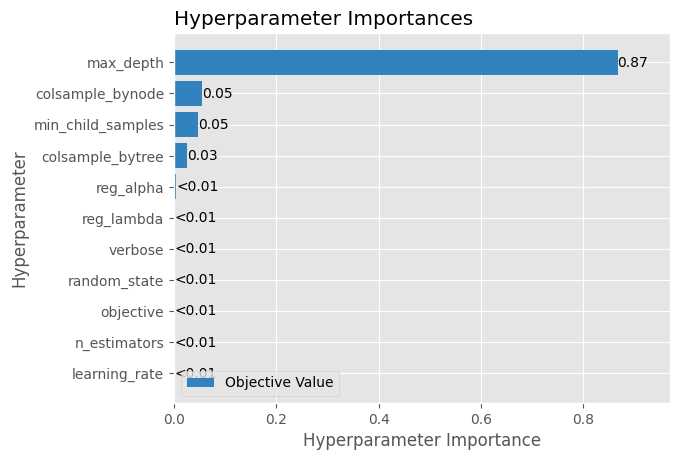

In [24]:
plot_param_importances(study_lgb_2);

In [8]:
best_params = {
    'n_estimators': 300,
    'learning_rate': 0.20701321225348068,
    'max_depth': 4,
    'min_child_samples': 1500,
    'reg_alpha': 0.27364853822678964,
    'reg_lambda': 0.015150234302393548,
    'colsample_bytree': 0.4585698361989257,
    'colsample_bynode': 0.8943213484326571,
    'objective': 'binary',
    'random_state': 10,
    'verbose': -1
}

# best_params = study_lgb_2.best_params

ratio = float(np.sum(y_train_ == 0)) / np.sum(y_train_ == 1)
eval_set = [(X_val, y_val)]

lgbm_clf_1 = lgb.LGBMClassifier(scale_pos_weight=ratio, **best_params)

lgbm_clf_1.fit(X_train_,
               y_train_,
               eval_metric="auc",
               eval_set=eval_set,
               callbacks=[lgb.log_evaluation(100),
                          lgb.early_stopping(100)])

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.827963	valid_0's binary_logloss: 0.491936
[200]	valid_0's auc: 0.836442	valid_0's binary_logloss: 0.470385
[300]	valid_0's auc: 0.839241	valid_0's binary_logloss: 0.4591
Did not meet early stopping. Best iteration is:
[295]	valid_0's auc: 0.839243	valid_0's binary_logloss: 0.459619


LGBMClassifier(colsample_bynode=0.8943213484326571,
               colsample_bytree=0.4585698361989257,
               learning_rate=0.20701321225348068, max_depth=4,
               min_child_samples=1500, n_estimators=300, objective='binary',
               random_state=10, reg_alpha=0.27364853822678964,
               reg_lambda=0.015150234302393548,
               scale_pos_weight=31.144624504655432, verbose=-1)

In [9]:
check_overfitting(model=lgbm_clf_1,
                  metric_fun=roc_auc_score,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)

roc_auc_score train: 0.869
roc_auc_score test: 0.840
delta = 3.5 %


In [28]:
metrics = pd.concat([
    metrics,
    get_metrics(y_test, lgbm_clf_1.predict(X_test),
                      lgbm_clf_1.predict_proba(X_test), w_test,
                      'LGBMClassifier_optuna_300e')
])

round(metrics.set_index('model'), 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.72993,0.83436,0.09183,0.78556,0.16444,0.65266
CatBoostClassifier_baseline_test,0.77309,0.84244,0.10396,0.74910,0.18258,0.66924
RandomForestClassifier_baseline_test,0.96618,0.79039,0.75000,0.00029,0.00057,0.56001
LGBMClassifier_optuna_300e,0.75982,0.83972,0.09946,0.75738,0.17584,0.66252


#### Holdout

In [17]:
class LGBVotingModel(BaseEstimator, ClassifierMixin):

    def __init__(self, **parameters):
        super().__init__()
        self.parameters = parameters
        self.estimators = []
        self.random_state = parameters.get('random_state',10)

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series,
            groups: pd.Series,
            eval_metric: str,
            n_folds: int = 3,
            shuffle: bool = True):

        cv = StratifiedGroupKFold(n_splits=n_folds,
                                  random_state=self.random_state,
                                  shuffle=shuffle)

        for fold, (idx_train,
                   idx_valid) in enumerate(cv.split(X, y, groups=groups)):
            X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
            X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

            ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
            eval_set = [(X_valid, y_valid)]

            lgb_model = lgb.LGBMClassifier(scale_pos_weight=ratio,
                                           **self.parameters)

            lgb_model.fit(
                X_train,
                y_train,
                eval_metric=eval_metric,
                eval_set=eval_set,
                callbacks=[lgb.log_evaluation(100),
                           lgb.early_stopping(100)])

            self.estimators.append(lgb_model)
            print(
                "Fold:", fold + 1, "ROC-AUC SCORE %.3f" %
                roc_auc_score(y_valid,
                              lgb_model.predict_proba(X_valid)[:, 1]))
            print("---")

        self._is_fitted = True
        return self

    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return stats.mode(np.column_stack(y_preds), axis=1)[0]

    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [18]:
lgb_voting_model = LGBVotingModel(**best_params)
lgb_voting_model.fit(X_train,
                     y_train,
                     groups=w_train,
                     eval_metric="auc",
                     n_folds=N_FOLDS,
                     shuffle=True)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.83107	valid_0's binary_logloss: 0.501531
[200]	valid_0's auc: 0.839212	valid_0's binary_logloss: 0.48273
[300]	valid_0's auc: 0.842144	valid_0's binary_logloss: 0.470611
Did not meet early stopping. Best iteration is:
[299]	valid_0's auc: 0.842167	valid_0's binary_logloss: 0.470726
Fold: 1 ROC-AUC SCORE 0.842
---
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.842641	valid_0's binary_logloss: 0.505226
[200]	valid_0's auc: 0.850406	valid_0's binary_logloss: 0.487979
[300]	valid_0's auc: 0.852372	valid_0's binary_logloss: 0.475956
Did not meet early stopping. Best iteration is:
[292]	valid_0's auc: 0.852422	valid_0's binary_logloss: 0.476652
Fold: 2 ROC-AUC SCORE 0.852
---
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.838943	valid_0's binary_logloss: 0.476664
[200]	valid_0's auc: 0.847809	valid_0's binary_logloss: 0.452012
[300]	

LGBVotingModel()

In [19]:
check_overfitting(model=lgb_voting_model,
                  metric_fun=roc_auc_score,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)

roc_auc_score train: 0.876
roc_auc_score test: 0.846
delta = 3.5 %


In [29]:
metrics = pd.concat([
    metrics,
    get_metrics(y_test, lgb_voting_model.predict(X_test),
                      lgb_voting_model.predict_proba(X_test), w_test,
                      'LGBMClassifier_optuna_cv_300e')
])

round(metrics.set_index('model'), 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.72993,0.83436,0.09183,0.78556,0.16444,0.65266
CatBoostClassifier_baseline_test,0.77309,0.84244,0.10396,0.74910,0.18258,0.66924
RandomForestClassifier_baseline_test,0.96618,0.79039,0.75000,0.00029,0.00057,0.56001
LGBMClassifier_optuna_300e,0.75982,0.83972,0.09946,0.75738,0.17584,0.66252
LGBMClassifier_optuna_cv_300e,0.76202,0.84606,0.10188,0.77214,0.18001,0.67682


### 1000 estimators

#### Search learning_rate

In [20]:
def objective_lgb3(trial, X, y, weeks, n_folds, random_state=10):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3,
                                             log=True),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "verbose": trial.suggest_categorical("verbose", [0]),
    }

    return lgb_fit_cross_validation(trial, X, y, weeks, n_folds, random_state,
                                    lgb_params)

In [21]:
%%time
study_lgb_3 = optuna.create_study(direction="maximize", 
                                  study_name="LGB3",
                                  pruner=optuna.pruners.SuccessiveHalvingPruner())
func = lambda trial: objective_lgb3(trial, X_train, y_train, w_train, 
                                   n_folds=N_FOLDS, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_lgb_3.optimize(func, n_trials=30, show_progress_bar=True)

print(f"\tBest value (auc): {study_lgb_3.best_value:.5f}")
print(f"\tBest params: {study_lgb_3.best_params}")

  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.773151	valid_0's binary_logloss: 0.1382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.783199	valid_0's binary_logloss: 0.137609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.780207	valid_0's binary_logloss: 0.132369
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.782897	valid_0's binary_logloss: 0.13577
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.77392	valid_0's binary_logloss: 0.132645
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.744121	valid_0's binary_logloss: 0.142785
Training until validation scores don't 

Early stopping, best iteration is:
[29]	valid_0's auc: 0.782615	valid_0's binary_logloss: 0.137616
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.781134	valid_0's binary_logloss: 0.132367
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.78351	valid_0's binary_logloss: 0.135762
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.77358	valid_0's binary_logloss: 0.132658
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.773244	valid_0's binary_logloss: 0.138206
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.781937	valid_0's binary_logloss: 0.13761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.750941	valid_0's binary_logloss: 0.185812
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.742809	valid_0's binary_logloss: 0.184238
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	valid_0's auc: 0.825468	valid_0's binary_logloss: 0.471379
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.831699	valid_0's binary_logloss: 0.53534
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's auc: 0.83459	valid_0's binary_logloss: 0.461793
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.822895	valid_0's binary_logloss: 0.480408
Training until validation scores don

#### Search other hyperparameters

In [24]:
def objective_lgb4(trial, X, y, weeks, n_folds, random_state=10):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.201557703425373]),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
#         "max_bin": trial.suggest_int("max_bin", 50, 300),
        "min_child_samples": trial.suggest_int("min_child_samples", 100, 70000, step=100),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
#         "reg_alpha": trial.suggest_int("reg_alpha", 0, 100),
#         "reg_lambda": trial.suggest_int("reg_lambda", 0, 100),
#         "min_split_gain": trial.suggest_int("min_split_gain", 0, 20),
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.9),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.4, 0.9),
        "objective": trial.suggest_categorical("objective", ["binary"]),
        "random_state": trial.suggest_categorical("random_state",
                                                  [random_state]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
    }
    
    return lgb_fit_cross_validation(trial, X, y, weeks, n_folds, random_state,
                                    lgb_params)

In [25]:
%%time
study_lgb_4 = optuna.create_study(direction="maximize", 
                                  pruner=optuna.pruners.SuccessiveHalvingPruner(),
                                  study_name="LGB_4")
func = lambda trial: objective_lgb4(trial, X_train, y_train, w_train, 
                                   n_folds=N_FOLDS, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_lgb_4.optimize(func, n_trials=30, show_progress_bar=True)

print(f"\tBest value (auc): {study_lgb_4.best_value:.5f}")
print(f"\tBest params: {study_lgb_4.best_params}")

  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[636]	valid_0's auc: 0.843448	valid_0's binary_logloss: 0.469849
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.853915	valid_0's binary_logloss: 0.470685
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[974]	valid_0's auc: 0.851701	valid_0's binary_logloss: 0.427644
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[702]	valid_0's auc: 0.844473	valid_0's binary_logloss: 0.474934
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[941]	valid_0's auc: 0.846131	valid_0's binary_logloss: 0.449514
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[699]	valid_0's auc: 0.84063	valid_0's binary_logloss:

Did not meet early stopping. Best iteration is:
[974]	valid_0's auc: 0.847649	valid_0's binary_logloss: 0.467185
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[489]	valid_0's auc: 0.840431	valid_0's binary_logloss: 0.449884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[358]	valid_0's auc: 0.850214	valid_0's binary_logloss: 0.473221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[548]	valid_0's auc: 0.849605	valid_0's binary_logloss: 0.412591
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[511]	valid_0's auc: 0.841161	valid_0's binary_logloss: 0.451867
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[603]	valid_0's auc: 0.842755	valid_0's binary_logloss: 0.427368
Training until validation scores don't improve for 100 rounds
Did not meet ea

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[985]	valid_0's auc: 0.847406	valid_0's binary_logloss: 0.459728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[756]	valid_0's auc: 0.84309	valid_0's binary_logloss: 0.4677
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's auc: 0.853404	valid_0's binary_logloss: 0.484093
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[953]	valid_0's auc: 0.852283	valid_0's binary_logloss: 0.432622
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[767]	valid_0's auc: 0.845503	valid_0's binary_logloss: 0.473786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[822]	valid_0's auc: 0.848791	valid_0's binary_logloss: 0.457014
Train

Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.853096	valid_0's binary_logloss: 0.441471
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[970]	valid_0's auc: 0.845178	valid_0's binary_logloss: 0.478848
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.846428	valid_0's binary_logloss: 0.467608
	Best value (auc): 0.84899
	Best params: {'n_estimators': 1000, 'learning_rate': 0.201557703425373, 'max_depth': 6, 'min_child_samples': 59200, 'reg_alpha': 1.5870626653704198, 'reg_lambda': 0.08870954489127132, 'colsample_bytree': 0.8987319208510414, 'colsample_bynode': 0.8307150795884893, 'objective': 'binary', 'random_state': 10, 'verbose': -1}
CPU times: total: 1d 6h 8min 36s
Wall time: 5h 9min 57s


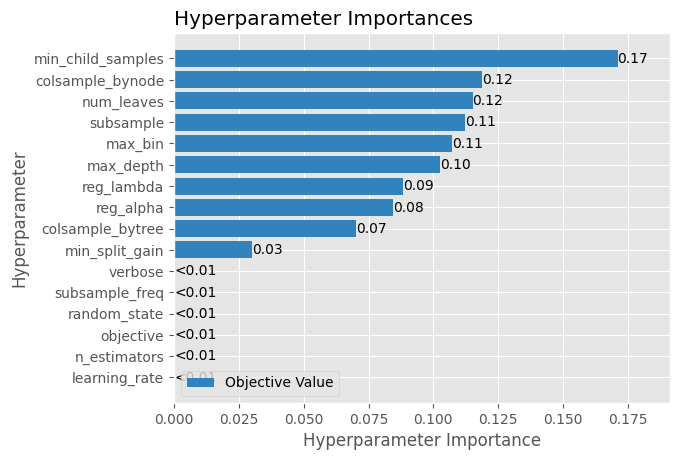

In [36]:
plot_param_importances(study_lgb_4);

In [30]:
best_params_2 = {
    'n_estimators': 1000,
    'learning_rate': 0.201557703425373,
    'max_depth': 6,
    'min_child_samples': 59200,
    'reg_alpha': 1.5870626653704198,
    'reg_lambda': 0.08870954489127132,
    'colsample_bytree': 0.8987319208510414,
    'colsample_bynode': 0.8307150795884893,
    'objective': 'binary',
    'random_state': 10,
    'verbose': -1
}

# best_params_2 = study_lgb_4.best_params

ratio = float(np.sum(y_train_ == 0)) / np.sum(y_train_ == 1)
eval_set = [(X_val, y_val)]

lgbm_clf_2 = lgb.LGBMClassifier(scale_pos_weight=ratio, **best_params_2)

lgbm_clf_2.fit(X_train_,
               y_train_,
               eval_metric="auc",
               eval_set=eval_set,
               callbacks=[lgb.log_evaluation(100),
                          lgb.early_stopping(100)])

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.828699	valid_0's binary_logloss: 0.495632
[200]	valid_0's auc: 0.837621	valid_0's binary_logloss: 0.480437
[300]	valid_0's auc: 0.841139	valid_0's binary_logloss: 0.472396
[400]	valid_0's auc: 0.842448	valid_0's binary_logloss: 0.466635
[500]	valid_0's auc: 0.843347	valid_0's binary_logloss: 0.461673
[600]	valid_0's auc: 0.843923	valid_0's binary_logloss: 0.457801
[700]	valid_0's auc: 0.844187	valid_0's binary_logloss: 0.454921
[800]	valid_0's auc: 0.844498	valid_0's binary_logloss: 0.450981
[900]	valid_0's auc: 0.844599	valid_0's binary_logloss: 0.44832
Early stopping, best iteration is:
[872]	valid_0's auc: 0.844679	valid_0's binary_logloss: 0.449487


LGBMClassifier(colsample_bynode=0.8307150795884893,
               colsample_bytree=0.8987319208510414,
               learning_rate=0.201557703425373, max_depth=6,
               min_child_samples=59200, n_estimators=1000, objective='binary',
               random_state=10, reg_alpha=1.5870626653704198,
               reg_lambda=0.08870954489127132,
               scale_pos_weight=31.144624504655432, verbose=-1)

In [31]:
check_overfitting(model=lgbm_clf_2,
                  metric_fun=roc_auc_score,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)

roc_auc_score train: 0.876
roc_auc_score test: 0.843
delta = 3.9 %


In [32]:
metrics = pd.concat([
    metrics,
    get_metrics(y_test, lgbm_clf_2.predict(X_test),
                lgbm_clf_2.predict_proba(X_test), w_test,
                'LGBMClassifier_optuna_1000e')
])

round(metrics.set_index('model'), 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.72993,0.83436,0.09183,0.78556,0.16444,0.65266
CatBoostClassifier_baseline_test,0.77309,0.84244,0.10396,0.74910,0.18258,0.66924
RandomForestClassifier_baseline_test,0.96618,0.79039,0.75000,0.00029,0.00057,0.56001
LGBMClassifier_optuna_300e,0.75982,0.83972,0.09946,0.75738,0.17584,0.66252
LGBMClassifier_optuna_cv_300e,0.76202,0.84606,0.10188,0.77214,0.18001,0.67682
LGBMClassifier_optuna_1000e,0.75977,0.84336,0.10069,0.76919,0.17806,0.67151


#### Holdout

In [33]:
lgb_voting_model2 = LGBVotingModel(**best_params_2)
lgb_voting_model2.fit(X_train,
                      y_train,
                      groups=w_train,
                      eval_metric="auc",
                      n_folds=N_FOLDS,
                      shuffle=True)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.828482	valid_0's binary_logloss: 0.51046
[200]	valid_0's auc: 0.837605	valid_0's binary_logloss: 0.49463
[300]	valid_0's auc: 0.841064	valid_0's binary_logloss: 0.485933
[400]	valid_0's auc: 0.84284	valid_0's binary_logloss: 0.479754
[500]	valid_0's auc: 0.843228	valid_0's binary_logloss: 0.475235
[600]	valid_0's auc: 0.843816	valid_0's binary_logloss: 0.4718
[700]	valid_0's auc: 0.844046	valid_0's binary_logloss: 0.468963
[800]	valid_0's auc: 0.844151	valid_0's binary_logloss: 0.465247
Early stopping, best iteration is:
[733]	valid_0's auc: 0.844262	valid_0's binary_logloss: 0.467929
Fold: 1 ROC-AUC SCORE 0.844
---
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.837667	valid_0's binary_logloss: 0.514478
[200]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.506545
[300]	valid_0's auc: 0.849672	valid_0's binary_logloss: 0.499437
[400]	valid_0's auc: 0.851653	vali

LGBVotingModel()

In [34]:
check_overfitting(model=lgb_voting_model2,
                  metric_fun=roc_auc_score,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)

roc_auc_score train: 0.881
roc_auc_score test: 0.848
delta = 3.9 %


In [35]:
metrics = pd.concat([
    metrics,
    get_metrics(y_test, lgb_voting_model2.predict(X_test),
                lgb_voting_model2.predict_proba(X_test), w_test,
                'LGBMClassifier_optuna_1000e_cv')
])

round(metrics.set_index('model'), 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.72993,0.83436,0.09183,0.78556,0.16444,0.65266
CatBoostClassifier_baseline_test,0.77309,0.84244,0.10396,0.74910,0.18258,0.66924
RandomForestClassifier_baseline_test,0.96618,0.79039,0.75000,0.00029,0.00057,0.56001
LGBMClassifier_optuna_300e,0.75982,0.83972,0.09946,0.75738,0.17584,0.66252
LGBMClassifier_optuna_cv_300e,0.76202,0.84606,0.10188,0.77214,0.18001,0.67682
LGBMClassifier_optuna_1000e,0.75977,0.84336,0.10069,0.76919,0.17806,0.67151
LGBMClassifier_optuna_1000e_cv,0.76253,0.84786,0.10263,0.77738,0.18133,0.68112


## RandomForest Tuning

####  Search hyperparameters

In [22]:
def objective_rf(trial, X, y, weeks, n_folds, random_state=10):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        'bootstrap': trial.suggest_categorical("bootstrap", [True]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_samples': trial.suggest_float('max_samples', 0.3, 0.99),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
        'class_weight': trial.suggest_categorical("class_weight", ['balanced']),
        'random_state': trial.suggest_categorical("random_state", [random_state]),
        'n_jobs': trial.suggest_categorical("n_jobs", [3]),
        "verbose": trial.suggest_categorical("verbose", [0]),
    }
    
    cv = StratifiedGroupKFold(n_splits=n_folds,
                              shuffle=True,
                              random_state=random_state)

    cv_predicts = np.empty(n_folds)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=weeks)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        
        preds = model.predict_proba(X_val)[:,1]
        cv_predicts[idx] = roc_auc_score(y_val, preds)

    return np.mean(cv_predicts)

In [23]:
%%time
study_rf = optuna.create_study(direction="maximize",
                               pruner=optuna.pruners.SuccessiveHalvingPruner(),
                               study_name="RF1")
func = lambda trial: objective_rf(trial, X_train_bin, y_train_bin, w_train_bin, 
                                  N_FOLDS, random_state=RAND)
study_rf.optimize(func, n_trials=10, show_progress_bar=True)

print(f"\tBest value (auc): {study_rf.best_value:.5f}")
print(f"\tBest params: {study_rf.best_params}")

  0%|          | 0/10 [00:00<?, ?it/s]

	Best value (auc): 0.80806
	Best params: {'n_estimators': 274, 'max_depth': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'min_samples_split': 13, 'max_samples': 0.7006486151941755, 'max_features': 'sqrt', 'class_weight': 'balanced', 'random_state': 10, 'n_jobs': 3, 'verbose': 0}
CPU times: total: 6h 23min 22s
Wall time: 2h 11min 4s


#### Holdout

In [37]:
class RFVotingModel(BaseEstimator, ClassifierMixin):

    def __init__(self, **parameters):
        super().__init__()
        self.parameters = parameters
        self.estimators = []
        self.random_state = parameters.get('random_state', 10)

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series,
            groups: pd.Series,
            eval_metric: str,
            n_folds: int = 3,
            shuffle: bool = True):

        cv = StratifiedGroupKFold(n_splits=n_folds,
                                  random_state=self.random_state,
                                  shuffle=shuffle)

        for fold, (idx_train,
                   idx_valid) in enumerate(cv.split(X, y, groups=groups)):
            X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
            X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

            model = RandomForestClassifier(**self.parameters)

            model.fit(X_train, y_train)

            self.estimators.append(model)
            print(
                "Fold:", fold + 1, "ROC-AUC SCORE %.3f" %
                roc_auc_score(y_valid,
                              model.predict_proba(X_valid)[:, 1]))
            print("---")

        self._is_fitted = True
        return self

    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return stats.mode(np.column_stack(y_preds), axis=1)[0]

    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [38]:
%%time

best_params_rf = {
    'n_estimators': 274,
    'max_depth': 14,
    'bootstrap': True,
    'min_samples_leaf': 6,
    'min_samples_split': 13,
    'max_samples': 0.7006486151941755,
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'random_state': 10,
    'n_jobs': 3,
    'verbose': 0
}
# best_params_rf = study_rf.best_params

voting_model4 = RFVotingModel(**best_params_rf)
voting_model4.fit(X_train_bin,
                  y_train_bin,
                  groups=w_train_bin,
                  eval_metric="auc",
                  n_folds=N_FOLDS,
                  shuffle=True)

Fold: 1 ROC-AUC SCORE 0.804
---
Fold: 2 ROC-AUC SCORE 0.812
---
Fold: 3 ROC-AUC SCORE 0.815
---
Fold: 4 ROC-AUC SCORE 0.806
---
Fold: 5 ROC-AUC SCORE 0.804
---
CPU times: total: 1h 35min 45s
Wall time: 32min 17s


RFVotingModel()

In [39]:
check_overfitting(model=voting_model4,
                  metric_fun=roc_auc_score,
                  X_train=X_train_bin,
                  y_train=y_train_bin,
                  X_test=X_test_bin,
                  y_test=y_test_bin)

roc_auc_score train: 0.897
roc_auc_score test: 0.805
delta = 11.5 %


In [40]:
metrics = pd.concat([
    metrics,
    get_metrics(y_test_bin, voting_model4.predict(X_test_bin),
                voting_model4.predict_proba(X_test_bin), w_test_bin,
                'RandomForestClassifier_optuna_cv')
])

metrics.set_index('model').style.highlight_max(axis=0, color='lightblue')

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.729930,0.834365,0.091831,0.785565,0.164439,0.652661
CatBoostClassifier_baseline_test,0.773091,0.842445,0.103959,0.749095,0.182580,0.669241
RandomForestClassifier_baseline_test,0.966177,0.790390,0.750000,0.000286,0.000571,0.560007
LGBMClassifier_optuna_300e,0.759817,0.839717,0.099464,0.757380,0.175835,0.662517
LGBMClassifier_optuna_cv_300e,0.762020,0.846057,0.101878,0.772139,0.180006,0.676819
LGBMClassifier_optuna_1000e,0.759775,0.843362,0.100686,0.769187,0.178063,0.671506
LGBMClassifier_optuna_1000e_cv,0.762532,0.847860,0.102632,0.777376,0.181326,0.681118
RandomForestClassifier_optuna_cv,0.861642,0.805039,0.121088,0.493715,0.194479,0.596975


## Catboost tuning

In [41]:
category_features = df_train.select_dtypes("category").columns.to_list()

#### Search learning_rate

In [49]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

grid = {
    "n_estimators": [100],
    "learning_rate": np.logspace(-3, -1, 3),
    "random_state": [RAND]
}

model = CatBoostClassifier(scale_pos_weight=ratio,
                           eval_metric="AUC",
                           cat_features=category_features,
                           silent=True,
                           thread_count=4)
grid_search_result = model.randomized_search(grid,
                                             X=X_train,
                                             y=y_train,
                                             stratified=True,
                                             plot=True)

print(f"\tBest params: {grid_search_result['params']}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7650385372
bestIteration = 95

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7650385	best: 0.7650385 (0)	total: 1m 49s	remaining: 3m 39s

bestTest = 0.7854399563
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7854400	best: 0.7854400 (1)	total: 3m 37s	remaining: 1m 48s

bestTest = 0.8342809478
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8342809	best: 0.8342809 (2)	total: 5m 25s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.832404658
bestIteration = 99

Training on fold [1/3]

bestTest = 0.8339569875
bestIteration = 99

Training on fold [2/3]

bestTest = 0.8342481663
bestIteration = 99

	Best params: {'random

#### Search other hyperparameters

In [51]:
grid = {
    "n_estimators": [1000],
    "learning_rate" : [0.1],
    "boosting_type": ['Ordered', 'Plain'],
    "max_depth": list(range(3, 12)),
    "l2_leaf_reg": np.logspace(-5, 2, 5),
    "bootstrap_type": ["Bayesian", "Bernoulli", "MVS", "No"],
    'border_count': [128, 254],
    'grow_policy': ["SymmetricTree", "Depthwise", "Lossguide"],    
    "random_state": [RAND]
}

model = CatBoostClassifier(scale_pos_weight=ratio,
                           eval_metric="AUC",
                           cat_features=category_features,
                           silent=True,
                           thread_count=4)
grid_search_result2 = model.randomized_search(grid,
                                             X=X_train,
                                             y=y_train,
                                             stratified=True,
                                             plot=True)

print(f"\tBest params: {grid_search_result2['params']}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8500549842
bestIteration = 996

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8500550	best: 0.8500550 (0)	total: 34m 10s	remaining: 5h 7m 33s

bestTest = 0.7984423802
bestIteration = 34

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7984424	best: 0.8500550 (0)	total: 3h 42m 27s	remaining: 14h 49m 49s

bestTest = 0.8464233761
bestIteration = 602

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8464234	best: 0.8500550 (0)	total: 5h 5m 48s	remaining: 11h 53m 33s

bestTest = 0.8503889148
bestIteration = 261

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8503889	best: 0.8503889 (3)	total: 7

In [52]:
catboost_best_params = grid_search_result2['params']

ratio = float(np.sum(y_train_ == 0)) / np.sum(y_train_ == 1)
eval_set = [(X_val, y_val)]

cat_boost_clf = CatBoostClassifier(scale_pos_weight=ratio,
                                   eval_metric="AUC",
                                   cat_features=category_features,
                                   thread_count = 3,
                                   **catboost_best_params)

cat_boost_clf.fit(X_train_,
                  y_train_,
                  eval_set=eval_set,
                  early_stopping_rounds=100,
                  verbose=False)

In [53]:
check_overfitting(model=cat_boost_clf,
                  metric_fun=roc_auc_score,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)

roc_auc_score train: 0.917
roc_auc_score test: 0.845
delta = 8.6 %


In [56]:
metrics = pd.concat([
    metrics,
    get_metrics(y_test, cat_boost_clf.predict(X_test),
                      cat_boost_clf.predict_proba(X_test), w_test,
                      'CatBoostClassifier_randsearch_1000e')
])

round(metrics.set_index('model'), 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.72993,0.83436,0.09183,0.78556,0.16444,0.65266
CatBoostClassifier_baseline_test,0.77309,0.84244,0.10396,0.74910,0.18258,0.66924
RandomForestClassifier_baseline_test,0.96618,0.79039,0.75000,0.00029,0.00057,0.56001
LGBMClassifier_optuna_300e,0.75982,0.83972,0.09946,0.75738,0.17584,0.66252
LGBMClassifier_optuna_cv_300e,0.76202,0.84606,0.10188,0.77214,0.18001,0.67682
LGBMClassifier_optuna_1000e,0.75977,0.84336,0.10069,0.76919,0.17806,0.67151
LGBMClassifier_optuna_1000e_cv,0.76253,0.84786,0.10263,0.77738,0.18133,0.68112
RandomForestClassifier_optuna_cv,0.86164,0.80504,0.12109,0.49372,0.19448,0.59698
CatBoostClassifier_randsearch_1000e,0.80511,0.84460,0.11459,0.70777,0.19724,0.67426


#### Holdout

In [61]:
class CatBoostVotingModel(BaseEstimator, ClassifierMixin):

    def __init__(self, **parameters):
        super().__init__()
        self.parameters = parameters
        self.estimators = []
        self.random_state = parameters.get('random_state', 10)

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series,
            groups: pd.Series,
            eval_metric: str,
            category_features: list[str],
            n_folds: int = 3,
            shuffle: bool = True):

        cv = StratifiedGroupKFold(n_splits=n_folds,
                                  random_state=self.random_state,
                                  shuffle=shuffle)

        for fold, (idx_train,
                   idx_valid) in enumerate(cv.split(X, y, groups=groups)):
            X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
            X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

            ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
            eval_set = [(X_valid, y_valid)]

            cat_boost_clf = CatBoostClassifier(scale_pos_weight=ratio,
                                               eval_metric=eval_metric,
                                               cat_features=category_features,
#                                                thread_count=3,
                                               **self.parameters)

            cat_boost_clf.fit(X_train,
                              y_train,
                              eval_set=eval_set,
                              early_stopping_rounds=100,
                              verbose=False)

            self.estimators.append(cat_boost_clf)
            print(
                "Fold:", fold + 1, "ROC-AUC SCORE %.3f" %
                roc_auc_score(y_valid,
                              cat_boost_clf.predict_proba(X_valid)[:, 1]))
            print("---")

        self._is_fitted = True
        return self

    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return stats.mode(np.column_stack(y_preds), axis=1)[0]

    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [62]:
catboost_voting_model = CatBoostVotingModel(**catboost_best_params)
catboost_voting_model.fit(X_train,
                     y_train,
                     groups=w_train,
                     eval_metric="AUC",
                     category_features=category_features,
                     n_folds=N_FOLDS,
                     shuffle=True)

Fold: 1 ROC-AUC SCORE 0.846
---
Fold: 2 ROC-AUC SCORE 0.856
---
Fold: 3 ROC-AUC SCORE 0.854
---
Fold: 4 ROC-AUC SCORE 0.848
---
Fold: 5 ROC-AUC SCORE 0.850
---


CatBoostVotingModel()

In [63]:
check_overfitting(model=catboost_voting_model,
                  metric_fun=roc_auc_score,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)

roc_auc_score train: 0.909
roc_auc_score test: 0.848
delta = 7.2 %


In [64]:
metrics = pd.concat([
    metrics,
    get_metrics(y_test, catboost_voting_model.predict(X_test),
                      catboost_voting_model.predict_proba(X_test), w_test,
                      'CatBoostClassifier_randseach_cv_1000e')
])

metrics.set_index('model').style.highlight_max(axis=0, color='lightblue')

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.729930,0.834365,0.091831,0.785565,0.164439,0.652661
CatBoostClassifier_baseline_test,0.773091,0.842445,0.103959,0.749095,0.182580,0.669241
RandomForestClassifier_baseline_test,0.966177,0.790390,0.750000,0.000286,0.000571,0.560007
LGBMClassifier_optuna_300e,0.759817,0.839717,0.099464,0.757380,0.175835,0.662517
LGBMClassifier_optuna_cv_300e,0.762020,0.846057,0.101878,0.772139,0.180006,0.676819
LGBMClassifier_optuna_1000e,0.759775,0.843362,0.100686,0.769187,0.178063,0.671506
LGBMClassifier_optuna_1000e_cv,0.762532,0.847860,0.102632,0.777376,0.181326,0.681118
RandomForestClassifier_optuna_cv,0.861642,0.805039,0.121088,0.493715,0.194479,0.596975
CatBoostClassifier_randsearch_1000e,0.805107,0.844596,0.114588,0.707770,0.197243,0.674262


# Summary

In [67]:
metrics.sort_values(
    by="gini_stability").set_index('model').style.highlight_max(
        axis=0, color='lightblue')

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
RandomForestClassifier_baseline_test,0.966177,0.790390,0.750000,0.000286,0.000571,0.560007
RandomForestClassifier_optuna_cv,0.861642,0.805039,0.121088,0.493715,0.194479,0.596975
LGBMClassifier_baseline_test,0.729930,0.834365,0.091831,0.785565,0.164439,0.652661
LGBMClassifier_optuna_300e,0.759817,0.839717,0.099464,0.757380,0.175835,0.662517
CatBoostClassifier_baseline_test,0.773091,0.842445,0.103959,0.749095,0.182580,0.669241
LGBMClassifier_optuna_1000e,0.759775,0.843362,0.100686,0.769187,0.178063,0.671506
CatBoostClassifier_randsearch_1000e,0.805107,0.844596,0.114588,0.707770,0.197243,0.674262
LGBMClassifier_optuna_cv_300e,0.762020,0.846057,0.101878,0.772139,0.180006,0.676819
LGBMClassifier_optuna_1000e_cv,0.762532,0.847860,0.102632,0.777376,0.181326,0.681118


- лучший результат по gini_stability(=0.681672) показывает CatBoostClassifier с подобранными параметрами для 1000 estimators и кросс-валидацией, но эта модель очень долго обучается (несколько часов)
- незначительно ниже(gini_stability = 0.681118) LGBMClassifier с кросс-валидацией и 1000 estimators

In [70]:
metrics.to_csv(f"tuning_metrics.csv", index=False)